# TAP_verify_DP0.1-truth_match

<br>Owner: **Douglas Tucker** ([@douglasleetucker](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@douglasleetucker))
<br>Updated for DC2 by:   Douglas Tucker  following in part work for DESC by Yao-Yuan Mao (@yymao) and Johann Cohen-Tanugi (@johannct)
<br>Last Verified to Run: **2021-08-20**
<br>Verified Stack Release: **w_2021_25**

### Objectives

This notebook is meant to run tests of the basic content of DP0.1 TAPserver `truth_match` table in the `dp01_dc2_catalogs` schema on the IDF.

### Logistics

This notebook is intended to be runnable on `data.lsst.cloud` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.


In [ ]:
# https://jira.lsstcorp.org/browse/PREOPS-473
# 
# create a separate notebook "for general consumption" (with more notes).
# More important now than comparing against parquet files.
# "Here's a description of what the DB looks like. -- a good product to hand off."
# Maybe do some of this within the SQL query:  can SQL test for NaN's?"
# Point towards the data, not so much the DB mechanics.
# Cols:  max, min, 1%, 99%
# qserv has a data return limit of 5GB; so beware!

### Set Up

In [2]:
# Import general python packages
import numpy as np
import pandas as pd
import os
from datetime import datetime
import gc
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [5]:
# Import the Rubin TAP service utilities
from rubin_jupyter_utils.lab.notebook import get_tap_service, retrieve_query, get_catalog

# Get an instance of the TAP service
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

Patching auth into notebook.base.handlers.IPythonHandler(notebook.base.handlers.AuthenticatedHandler) -> IPythonHandler(jupyterhub.singleuser.mixins.HubAuthenticatedHandler, notebook.base.handlers.AuthenticatedHandler)


### User Input

In [6]:
# Which table are we interested in for this notebook?
schema_name = 'dp01_dc2_catalogs'
table_name = 'truth_match'
table_full_name = """%s.%s""" % (schema_name, table_name)

# Output directory and output file basename info
outputDir = '/home/douglasleetucker/WORK'
baseName = 'TAP_verify_DP01'

# Debug option for quick results for testing purposes:
#    True:  only runs over a few tracts of data
#    False:  runs over all tracts available
debug = False

# Do query step (e.g., if this very long step hasn't already been run before)?
do_query_step = False

# Do analysis step (e.g., if this long step hasn't already been run before?)
do_analysis_step = False

# Do plotting step (e.g., if this step hasn't already been run before?)
do_plotting_step = True

# Do final cleanup?
do_final_cleanup = False

# Level of output to screen (0, 1, 2, ...)
verbose = 2

### Useful Modules

In [7]:
# # # # # # # # # # # # # # # # # # # #
# Plotting module...                  #
# # # # # # # # # # # # # # # # # # # #

def makeTractSanityPlots(df, column_name, table_full_name, outputFileName, nbins=50):

    # 
    # Define binning parameters for the different plots
    # 

    # values
    alist = []
    alist.extend(list(df[df['column']==column_name]['1%'].values))
    alist.extend(list(df[df['column']==column_name]['50%'].values))
    alist.extend(list(df[df['column']==column_name]['99%'].values))
    val_range = max(alist) - min(alist)
    val_min = min(alist) - 0.10*val_range
    val_max = max(alist) + 0.10*val_range
    val_nbins = nbins
    delta_val = (val_max - val_min)/val_nbins
    val_bins = np.arange(val_min, val_max, delta_val)
    if verbose> 2:  print(val_bins)

    # numbers
    alist = []
    alist.extend(list(df[df['column']==column_name]['n_nan'].values))
    alist.extend(list(df[df['column']==column_name]['n_tot'].values))
    num_range = max(alist) - min(alist)
    num_min = 0
    num_max = max(alist) + 0.10*val_range
    num_nbins = nbins
    delta_num = (num_max - num_min)/num_nbins
    num_bins = np.arange(num_min, num_max, delta_num)
    if verbose> 2:  print(num_bins)

    # fractions
    frac_min = 0.00
    frac_max = 1.00
    frac_nbins = nbins
    delta_frac = (frac_max - frac_min)/frac_nbins
    frac_bins = np.arange(frac_min, frac_max, delta_frac)
    if verbose> 2:  print(frac_bins)
        
    #
    # Plot plots...
    #

    fig = plt.figure(figsize=(20,10))

    fig.subplots_adjust(hspace=0.5)
    supTitle = """Tract-Level Diagnostics\nTable:  %s\nColumn:  %s""" % (table_full_name, column_name) 
    fig.suptitle(supTitle)
    plt.rcParams.update({'font.size': 14})

    plt.subplot(322)
    values = (df[df['column']==column_name]['1%']).values
    ax = plt.hist(values, bins=val_bins)
    plt.title("quantile: 1%", x=0.50, y =0.80)
    plt.xlabel(column_name)
    plt.ylabel('# Tracts')
    plt.grid(True)
    plt.grid(color='grey')

    plt.subplot(324)
    values = (df[df['column']==column_name]['50%']).values
    ax = plt.hist(values, bins=val_bins)
    plt.title("quantile: 50%", x=0.50, y =0.80)
    plt.xlabel(column_name)
    plt.ylabel('# Tracts')
    plt.grid(True)
    plt.grid(color='grey')

    plt.subplot(326) 
    values = (df[df['column']==column_name]['99%']).values
    ax = plt.hist(values, bins=val_bins)
    plt.title("quantile: 99%", x=0.50, y =0.80)
    plt.xlabel(column_name)
    plt.ylabel('# Tracts')
    plt.grid(True)
    plt.grid(color='grey')

    plt.subplot(321) 
    values = (df[df['column']==column_name]['n_nan']).values
    ax = plt.hist(values, bins=num_bins)
    plt.title("N_nan", x=0.50, y =0.80)
    plt.xlabel('n_nan')
    plt.ylabel('# Tracts')
    plt.grid(True)
    plt.grid(color='grey')

    plt.subplot(323) 
    values = (df[df['column']==column_name]['n_tot']).values
    ax = plt.hist(values, bins=num_bins)
    plt.title("N_tot", x=0.50, y =0.80)
    plt.xlabel('n_tot')
    plt.ylabel('# Tracts')
    plt.grid(True)
    plt.grid(color='grey')

    plt.subplot(325) 
    values = (df[df['column']==column_name]['f_nan']).values
    ax = plt.hist(values, bins=frac_bins)
    plt.title("Frac_nan", x=0.50, y =0.80)
    plt.xlabel('Fraction of NaNs')
    plt.ylabel('# Tracts')
    plt.grid(True)
    plt.grid(color='grey')
    
    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)


    return 0

### Basic Tests

Since some of the following queries take time, let's measure how long it takes to complete each query cell.  We will use `%%time` to estimate processor and wall clock time, and `datetime.now()` to estimate the total time to send the query and download its results.

In [8]:
%%time
now0=datetime.now()
    
query = """SELECT COUNT(*) FROM %s""" % (table_full_name)
results = service.search(query)
df = results.to_table().to_pandas()
ntot = df['COUNT'].loc[0]
outputLine = """%40s:  %d""" % (table_full_name, ntot)
print(outputLine)

now1=datetime.now()
print("Total time:", now1-now0)

           dp01_dc2_catalogs.truth_match:  765823615
Total time: 0:00:06.923884
CPU times: user 15.7 ms, sys: 213 µs, total: 15.9 ms
Wall time: 6.92 s


Let's see what `tracts` are available in the `dp01_dc2_catalogs.truth_match` table.

In [9]:
%%time
now0=datetime.now()

query = """SELECT DISTINCT tract FROM %s ORDER BY tract""" % (table_full_name)

results = service.search(query)

df = results.to_table().to_pandas()
tract_list = df['tract'].tolist()

now1=datetime.now()
print("Total time:", now1-now0)

print(tract_list)

Total time: 0:00:09.911339
[2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4636, 4637, 4638, 4639, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 4850, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859, 4860, 5065, 5066, 5067, 5068, 5069, 5070, 

### Detailed Tests

These tests take a long time (c. 16 hours).  First perform asynchronous queries on for each of the tracts save the URLs containing the results in a CSV file (in case the job fails; so no need to start completely from scratch.)

In [10]:
%%time

# The job urls are saved in a file...  just in case...
urls_file_name = """%s.%s.urls.csv""" % (baseName, table_name)
urls_file_name = os.path.join(outputDir,urls_file_name)
print(urls_file_name)

n_tracts = len(tract_list)


# If you have already run this step and haven't run the clean-up step, 
#  you probably want to skip this step ...
if do_query_step==True:

    fout = open(urls_file_name, 'w')
    outputLine = 'tract,url\n'
    fout.write(outputLine)
    fout.close()

    print("""The list of job URLs is being saved in %s, just in case the notebook crashes""" % urls_file_name)

    job = {}

    for tract in tract_list:
    
        ## restart:
        #if tract < 4439: continue
    
        now0=datetime.now()

        i_tract = tract_list.index(tract) + 1
        print("""Tract %d  (%d/%d) """ % (tract, i_tract, n_tracts))
        
        now0=datetime.now()
        query = """SELECT * FROM %s WHERE tract=%d""" % (table_full_name, tract)
        print(query)

        # First, submit the job.  This creates it but doesn't run the query yet.
        job[tract] = service.submit_job(query)

        # Here's the URL representing your query.  This is what you need to retrieve
        # the data again.
        print('Job URL is', job[tract].url)
    
        # Save the tract and URL to urls_file_name...
        fout = open(urls_file_name, 'a')
        outputLine = """%d,%s\n""" % (tract, str(job[tract].url))
        fout.write(outputLine)
        fout.close()

        # Here you can see the job's phase, which is PENDING.
        print('Job phase is', job[tract].phase)

        # Now, run the query.
        job[tract].run()

        # Here, you can tell python to wait for the job to finish if you don't want to
        # run anything else while you are waiting.  Then we print out the final state.
        job[tract].wait(phases=['COMPLETED', 'ERROR'])
        print('Job phase is', job[tract].phase)

        # Here's a helpful function that will raise an exception if
        # your query had an unfortunate incident.
        job[tract].raise_if_error()

        now1=datetime.now()
        print("Total time:", now1-now0)
        print("")

        # If we are debugging, let's exit this loop after doing 3 tracts...
        if debug == True:
            if i_tract == 3: break

/home/douglasleetucker/WORK/TAP_verify_DP01.truth_match.urls.csv
CPU times: user 0 ns, sys: 111 µs, total: 111 µs
Wall time: 82 µs


In [11]:
# Reset pandas display.max_colwidth to large number; otherwise URL name is truncated...
pd.set_option("display.max_colwidth", 10000)
df_urls = pd.read_csv(urls_file_name, index_col='tract', )

if verbose > 1:
    print(df_urls.head(5))
    print(".\n.\n.")
    print(df_urls.tail(5))

                                                          url
tract                                                        
2723   https://data.lsst.cloud/api/tap/async/o93g23qyq8nrakui
2724   https://data.lsst.cloud/api/tap/async/g1haj12py7c5gkca
2725   https://data.lsst.cloud/api/tap/async/fw51s7ef6vxkeouw
2726   https://data.lsst.cloud/api/tap/async/svgo8a6eugy7tv3i
2727   https://data.lsst.cloud/api/tap/async/st8ouol4dzjj20m6
.
.
.
                                                          url
tract                                                        
5070   https://data.lsst.cloud/api/tap/async/g7b21052k6ws1qhs
5071   https://data.lsst.cloud/api/tap/async/p9m92sl9w7cn9ep5
5072   https://data.lsst.cloud/api/tap/async/bshq2rm2thgzhsxp
5073   https://data.lsst.cloud/api/tap/async/m1d705et8celbssc
5074   https://data.lsst.cloud/api/tap/async/vchz3gyq37f171zd


In [12]:
#raise StopExecution

### Run analysis on returned results for each tract.  Save results in output file...

In [13]:
%%time

# Create a CSV file to output results from all the tracts...
metaOutputFile = """%s.%s.csv""" % (baseName, table_name)
metaOutputFile = os.path.join(outputDir, metaOutputFile)

if do_analysis_step==True:

    # Write out header line to the metaOutputFile...
    fmout = open(metaOutputFile, 'w')
    metaOutputLine = """tract,column,1%,50%,99%,n_nan,n_tot\n"""
    fmout.write(metaOutputLine)
    fmout.close()

    # Loop over tracts in tract_list...
    for tract in tract_list:
    
        i_tract = tract_list.index(tract) + 1
        print("""Tract %d  (%d/%d) """ % (tract, i_tract, n_tracts))
        
        #if tract < 4644:
        #    continue

        outputFile = """%s.%s.%d.txt""" % (baseName, table_name, tract)
        outputFile = os.path.join(outputDir, outputFile)
    
        try:
            # Grab results...
            job_url = df_urls.loc[tract, 'url']
            print(job_url)
            retrieved_job = retrieve_query(job_url)
            results = retrieved_job.fetch_result()
    
            # Convert the results a Pandas DataFrame...
            df = results.to_table().to_pandas()

            # Output column titles...
            outputLine = '                   column\t        1%         50%         99%       n(Nan)        ntot\n'
            outputLine = outputLine + \
                         '                   ------\t        --         ---         ---       ------        ----\n'
            fout = open(outputFile, 'w')
            fout.write(outputLine)
            fout.close()
    
            # Loop over each column, calculating and outputting the stats...
            for colname in df.columns:
                outputLine1 = "%25s:\t" % (colname)
                metaOutputLine1 = "%d,%s," % (tract, colname)
                try:
                    x = df[colname].quantile([0.01, 0.50, 0.99])
                    outputLine2 = "%10.4g  %10.4g  %10.4g" % (x[0.01], x[0.50], x[0.99])
                    metaOutputLine2 = "%.4g,%.4g,%.4g," % (x[0.01], x[0.50], x[0.99])
                except:
                    outputLine2 = "       ...         ...         ..."
                    metaOutputLine2 = ",,,"
                ntot = len(df.index)
                ntot_nan = df[colname].isna().sum()
                outputLine3 = "          %d          %d" % (ntot_nan, ntot)
                metaOutputLine3 = "%d,%d" % (ntot_nan, ntot)
                outputLine = outputLine1+outputLine2+outputLine3+'\n'
                metaOutputLine = metaOutputLine1+metaOutputLine2+metaOutputLine3+'\n'
                fout = open(outputFile, 'a')
                fout.write(outputLine)
                fout.close()
                fmout = open(metaOutputFile, 'a')
                fmout.write(metaOutputLine)
                fmout.close()

            # Clear memory, make space
            del df, results; gc.collect()   

        except:
        
            print("FAILED")
            outputLine = "FAILED\n"
            fout = open(outputFile, 'w')
            fout.write(outputLine)
            fout.close()
            
        #break


CPU times: user 0 ns, sys: 19 µs, total: 19 µs
Wall time: 22.9 µs


In [14]:
meta_df = pd.read_csv(metaOutputFile)
meta_df['f_nan'] = meta_df['n_nan']/meta_df['n_tot']
meta_df

Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


,tract,column,1%,50%,99%,n_nan,n_tot,f_nan
0,2723,cosmodc2_hp,1.032000e+04,1.044000e+04,1.044000e+04,0,3867042,0.0
1,2723,cosmodc2_id,1.094000e+10,1.157000e+10,1.158000e+10,0,3867042,0.0
2,2723,dec,-4.609000e+01,-4.526000e+01,-4.464000e+01,0,3867042,0.0
3,2723,flux_g,3.354000e+00,1.832000e+01,1.489000e+03,0,3867042,0.0
4,2723,flux_g_noMW,3.555000e+00,1.946000e+01,1.581000e+03,0,3867042,0.0
...,...,...,...,...,...,...,...,...
4975,5074,patch,NaN,NaN,NaN,0,4819476,0.0
4976,5074,ra,7.052000e+01,7.133000e+01,7.215000e+01,0,4819476,0.0
4977,5074,redshift,1.742000e-01,1.392000e+00,2.975000e+00,0,4819476,0.0
4978,5074,tract,5.074000e+03,5.074000e+03,5.074000e+03,0,4819476,0.0


In [15]:
#colname = 'blendedness'
#status = makeTractSanityPlots(meta_df, colname, table_full_name, nbins=50)

In [16]:
#meta_df[meta_df['column']=="blendedness"].hist(['99%'])

cosmodc2_hp:  TAP_verify_DP01.dp01_dc2_catalogs.truth_match.cosmodc2_hp.png
cosmodc2_id:  TAP_verify_DP01.dp01_dc2_catalogs.truth_match.cosmodc2_id.png
dec:  TAP_verify_DP01.dp01_dc2_catalogs.truth_match.dec.png
flux_g:  TAP_verify_DP01.dp01_dc2_catalogs.truth_match.flux_g.png
flux_g_noMW:  TAP_verify_DP01.dp01_dc2_catalogs.truth_match.flux_g_noMW.png
flux_i:  TAP_verify_DP01.dp01_dc2_catalogs.truth_match.flux_i.png
flux_i_noMW:  TAP_verify_DP01.dp01_dc2_catalogs.truth_match.flux_i_noMW.png
flux_r:  TAP_verify_DP01.dp01_dc2_catalogs.truth_match.flux_r.png
flux_r_noMW:  TAP_verify_DP01.dp01_dc2_catalogs.truth_match.flux_r_noMW.png
flux_u:  TAP_verify_DP01.dp01_dc2_catalogs.truth_match.flux_u.png
flux_u_noMW:  TAP_verify_DP01.dp01_dc2_catalogs.truth_match.flux_u_noMW.png
flux_y:  TAP_verify_DP01.dp01_dc2_catalogs.truth_match.flux_y.png
flux_y_noMW:  TAP_verify_DP01.dp01_dc2_catalogs.truth_match.flux_y_noMW.png
flux_z:  TAP_verify_DP01.dp01_dc2_catalogs.truth_match.flux_z.png
flux_z_noMW:

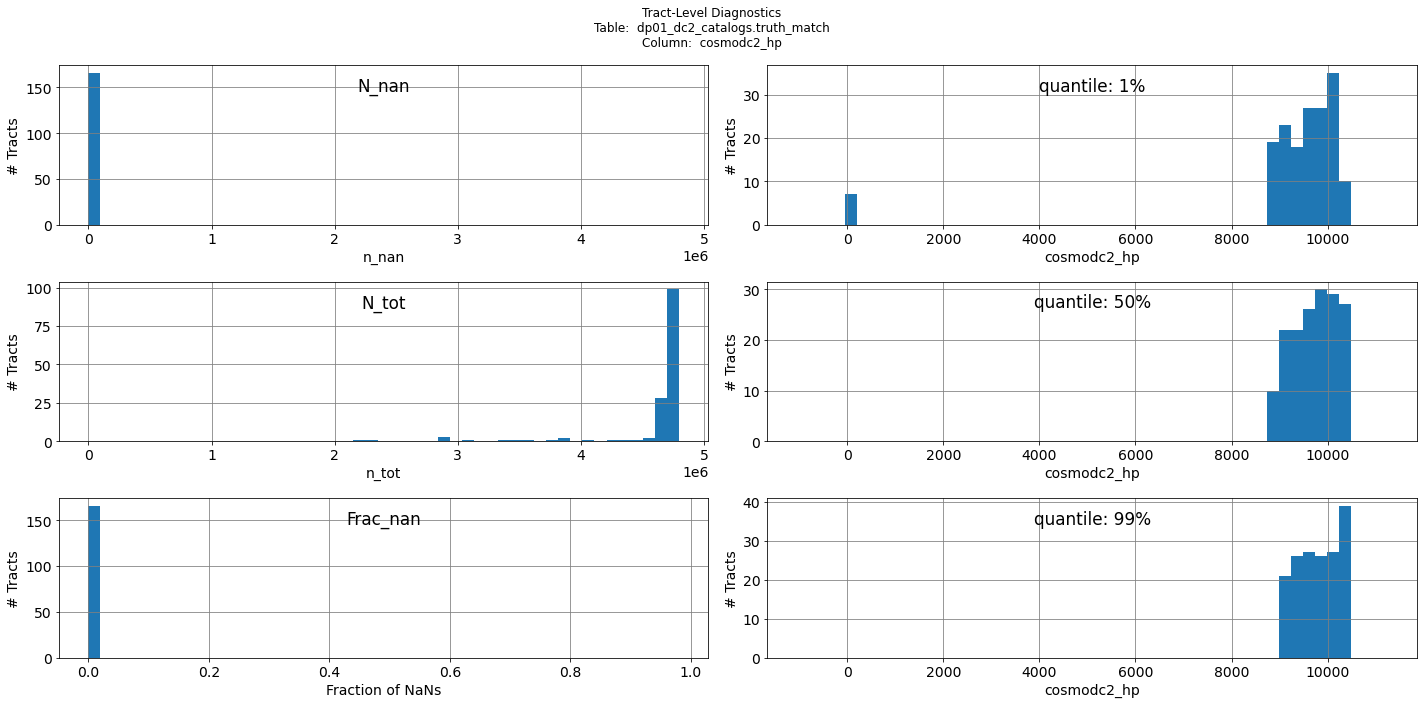

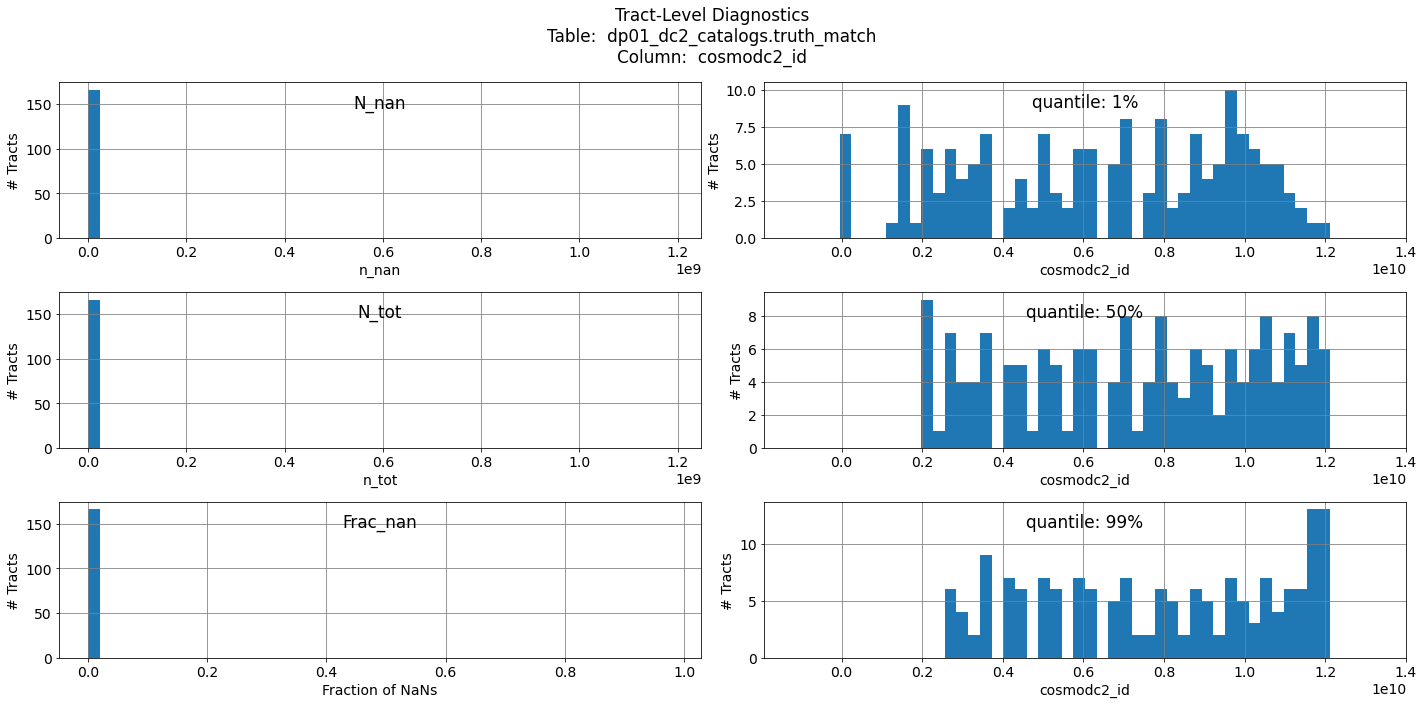

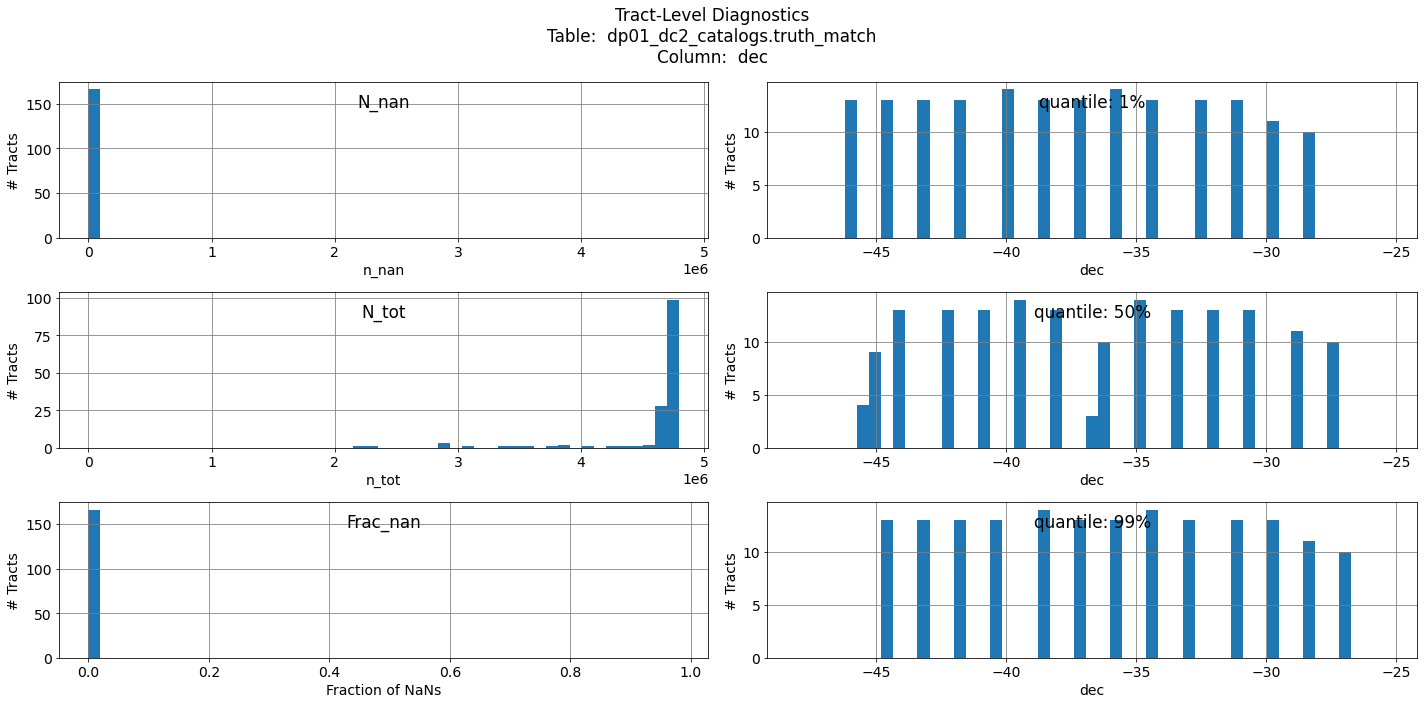

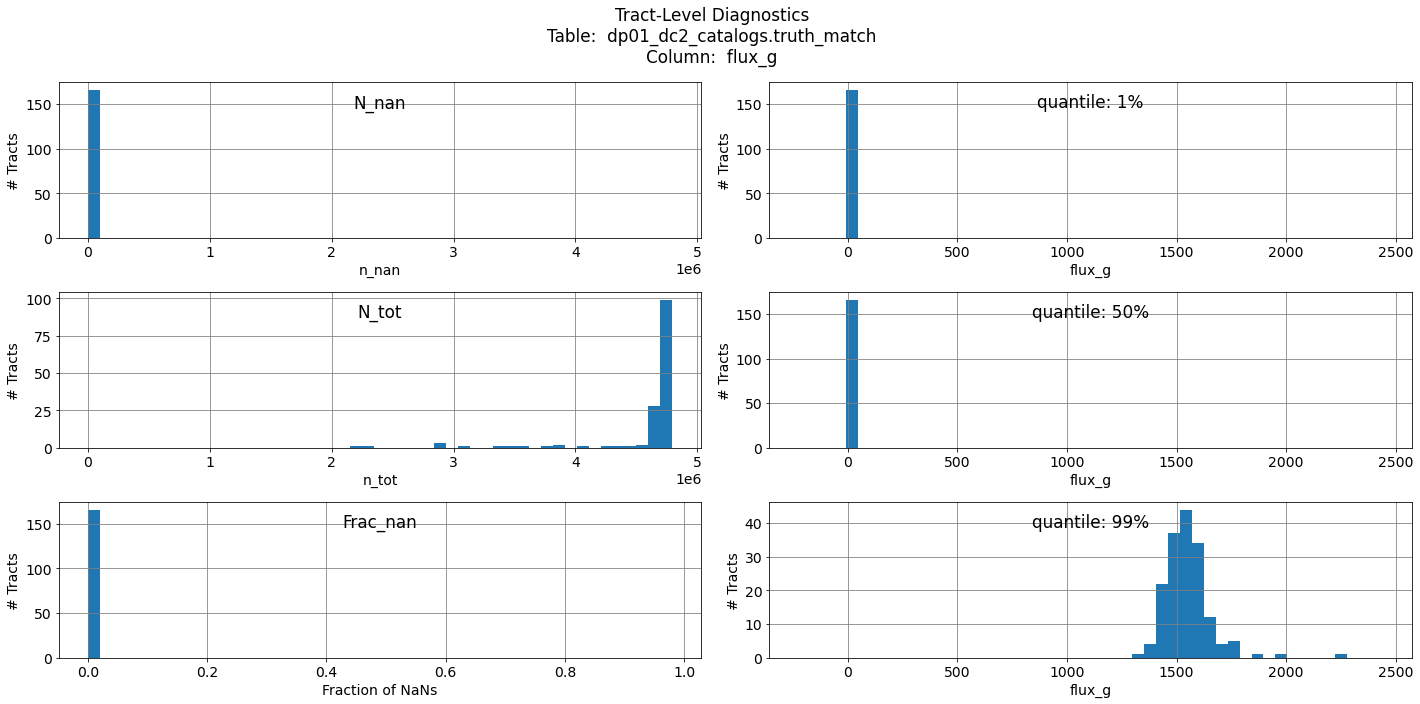

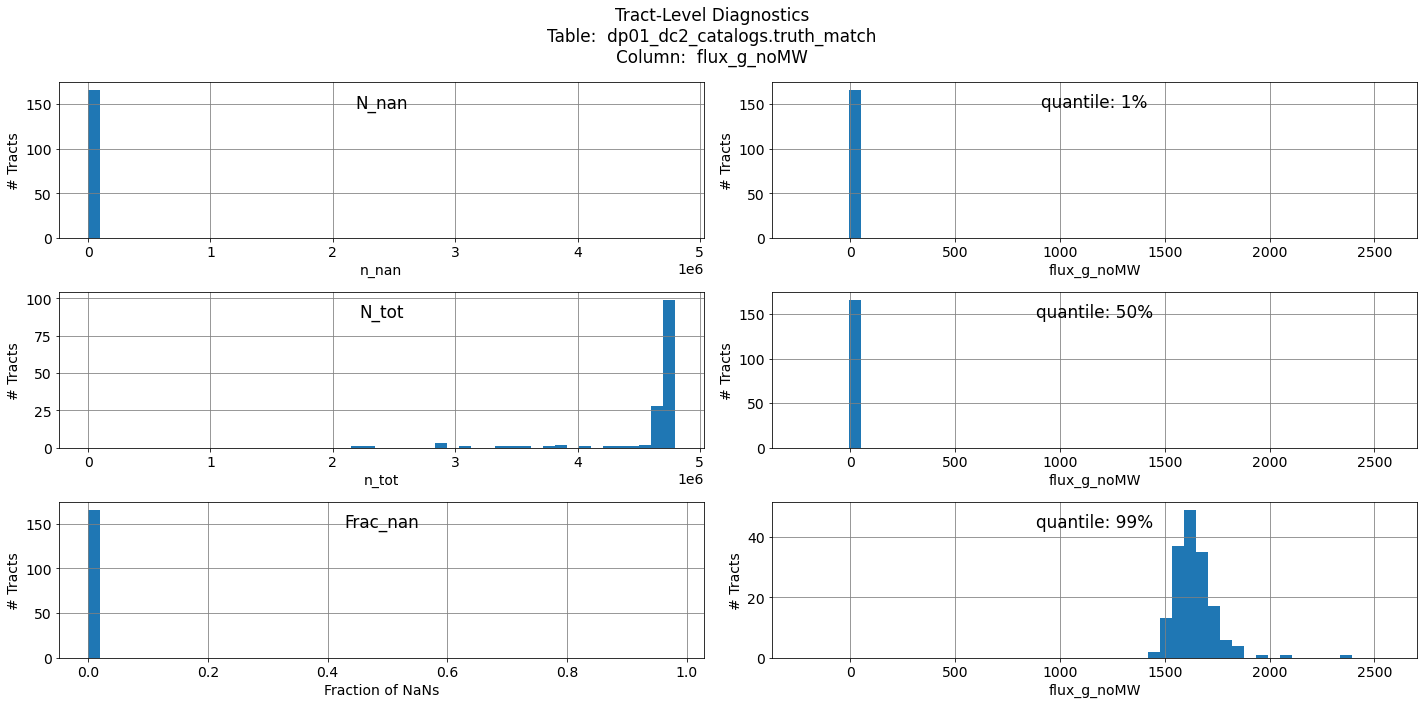

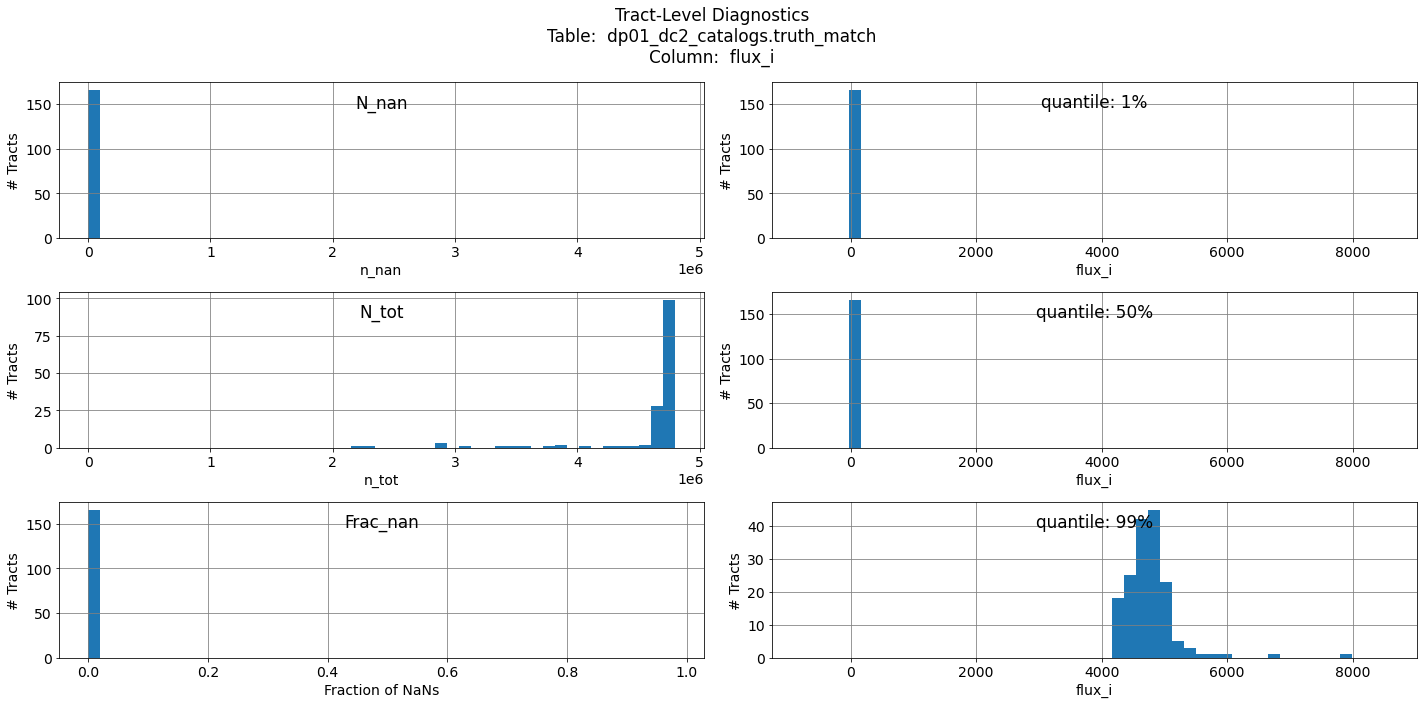

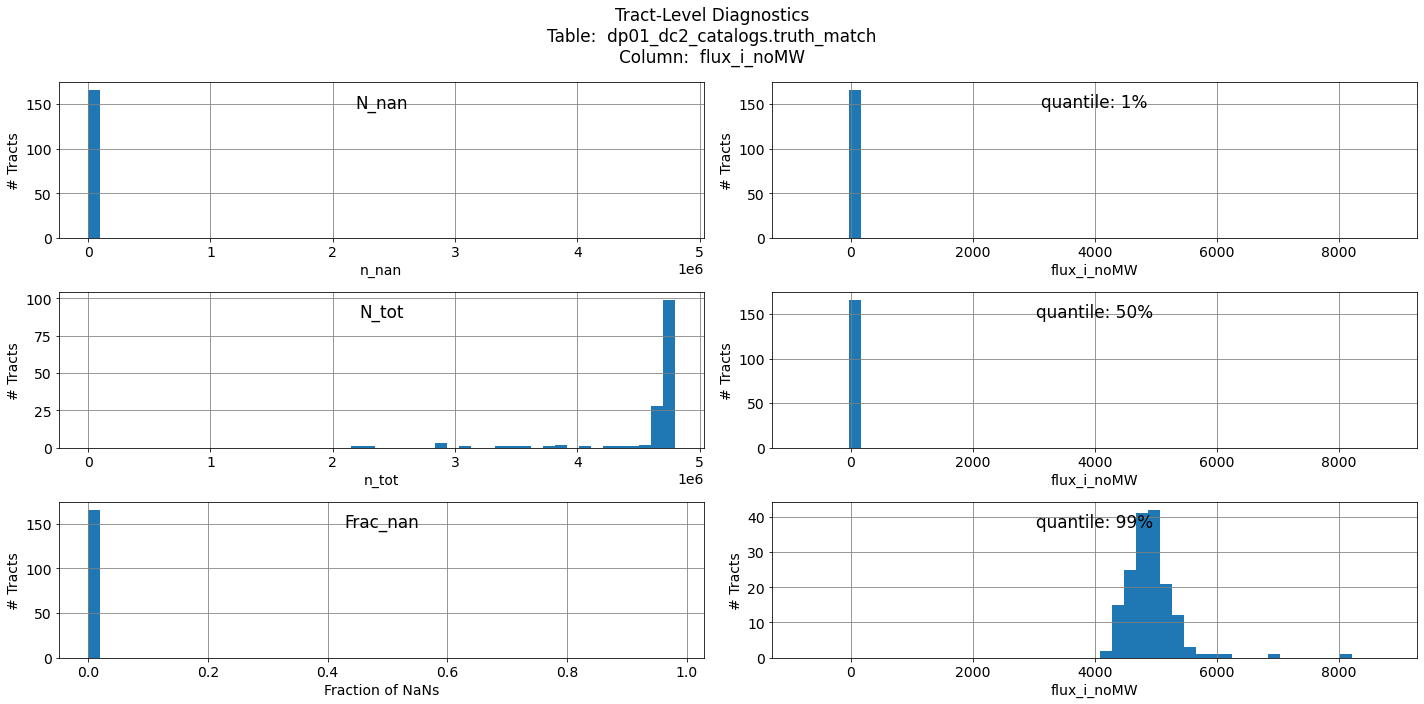

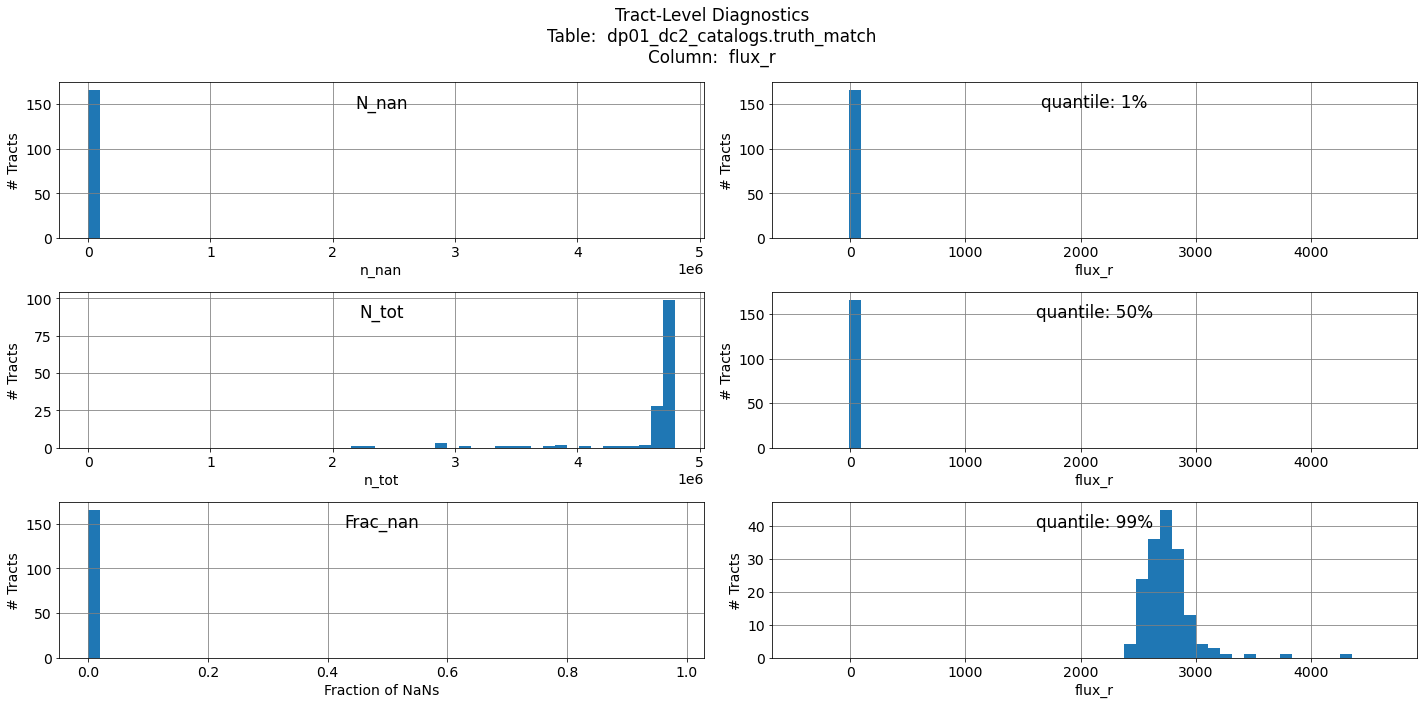

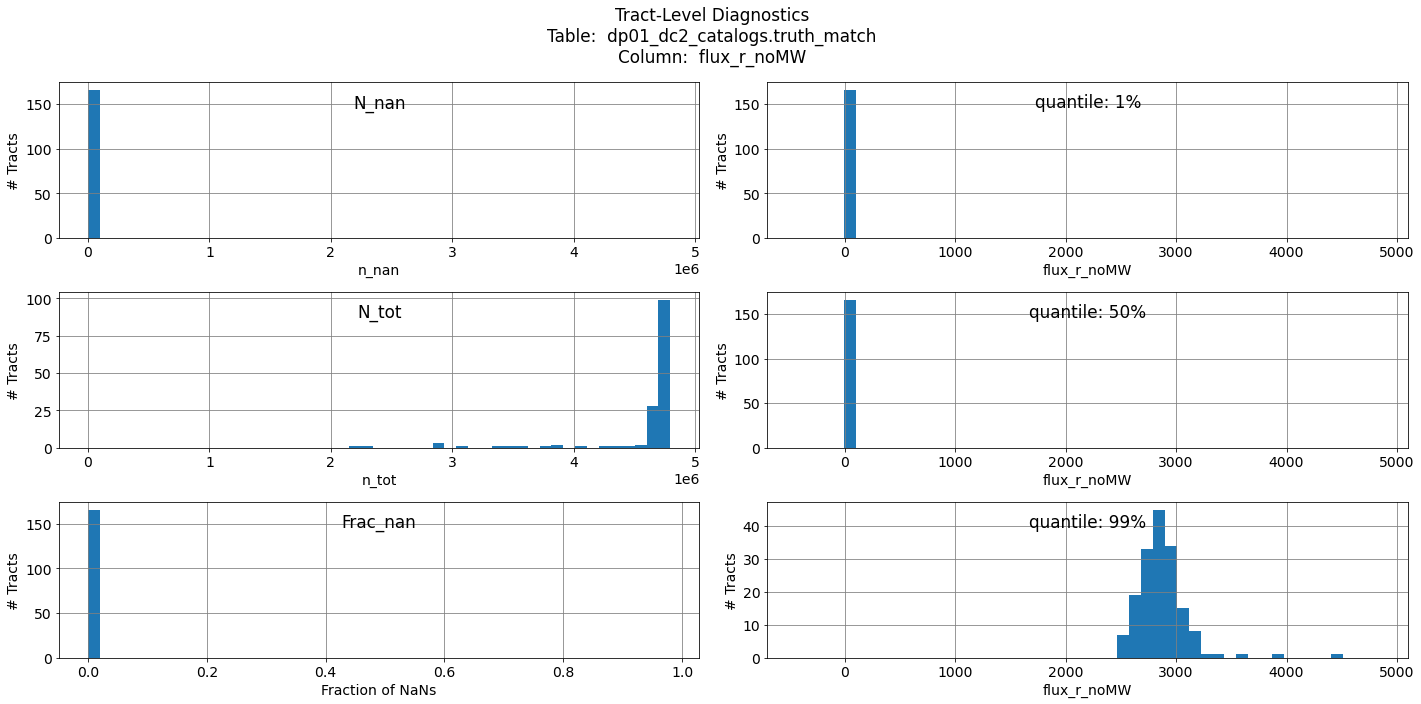

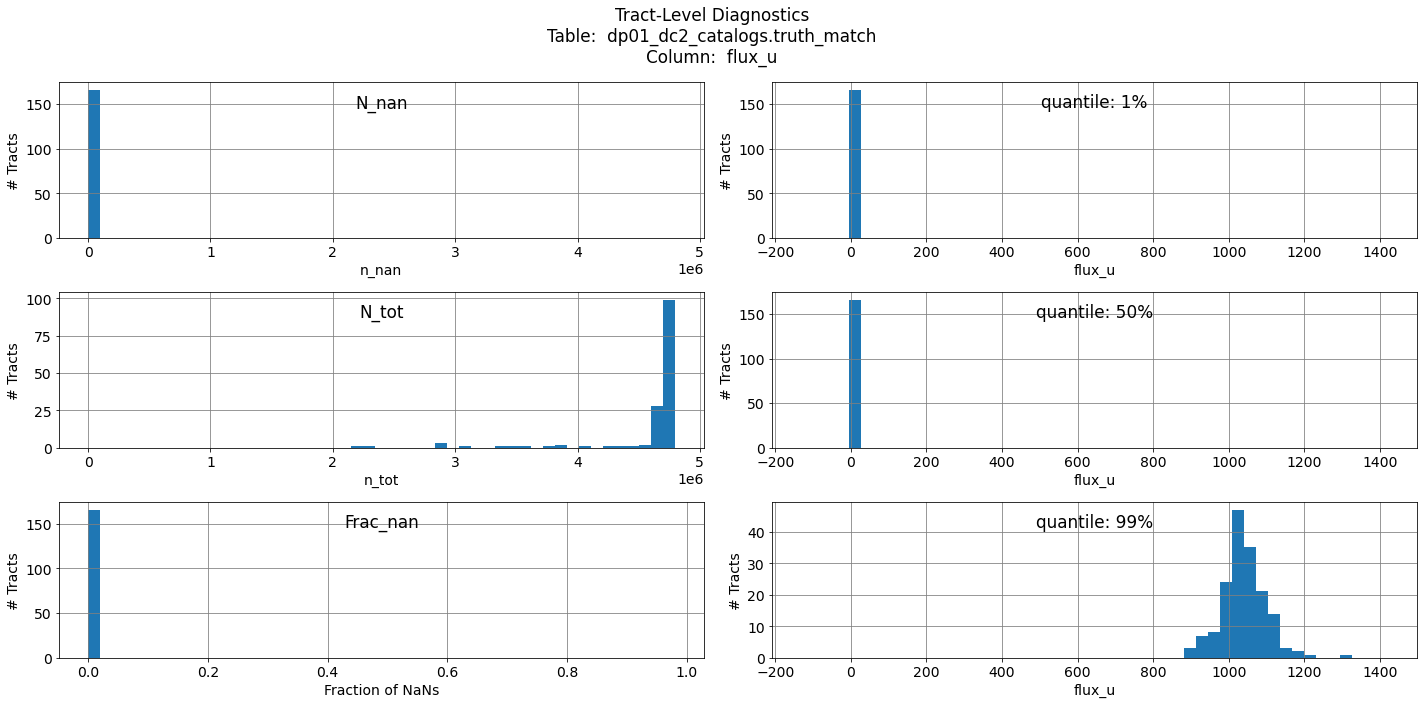

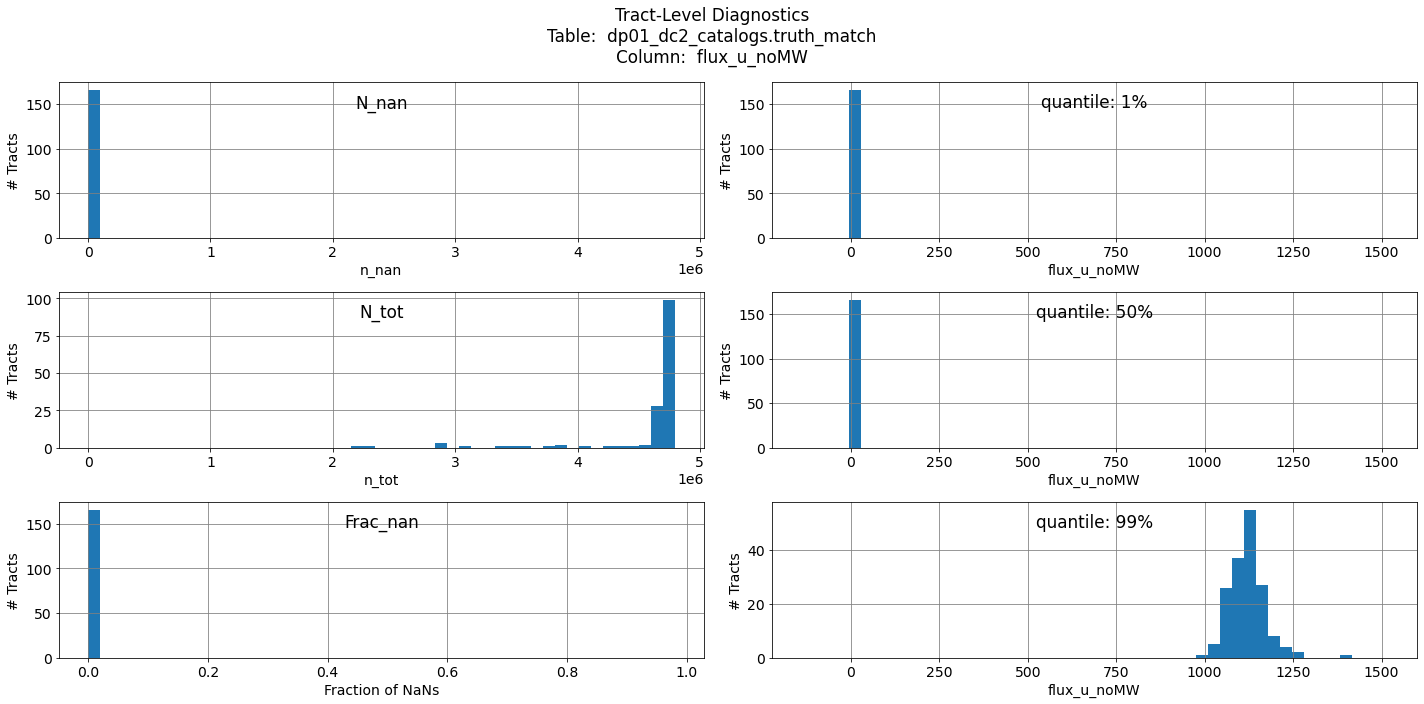

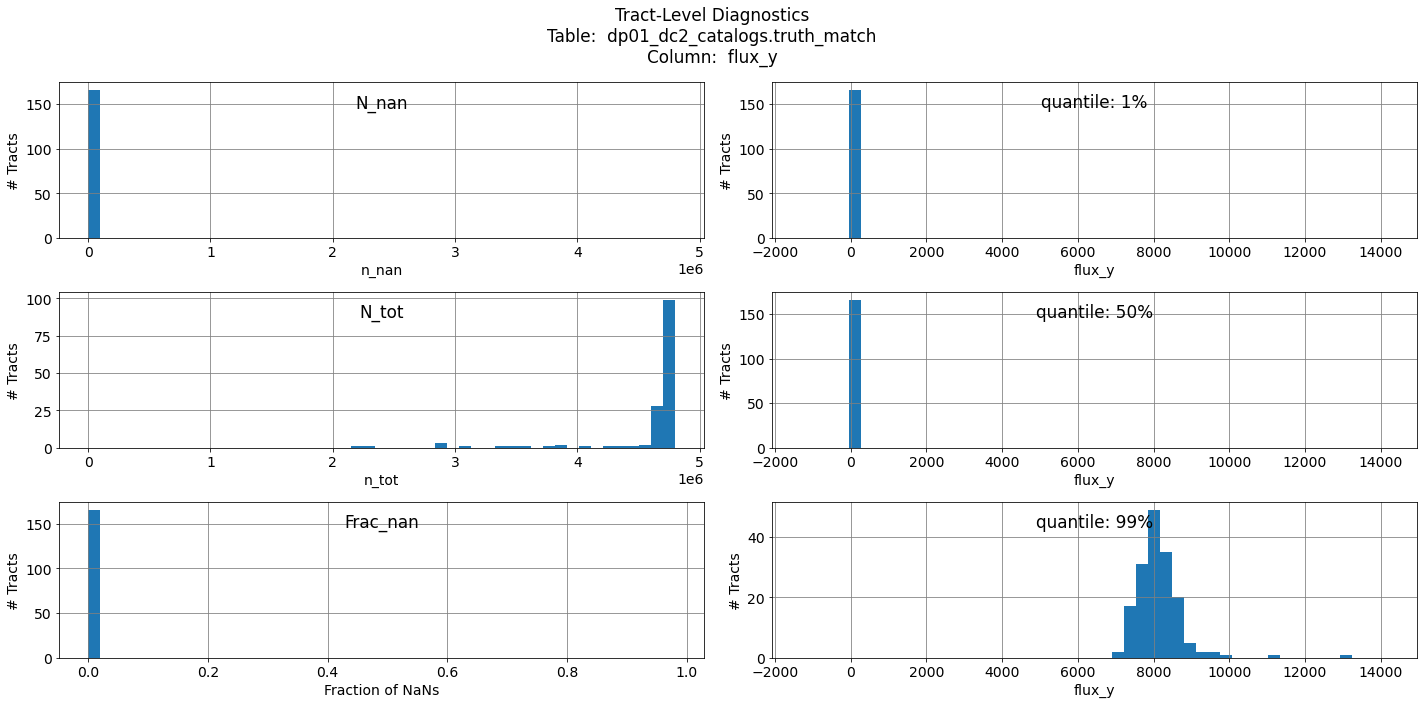

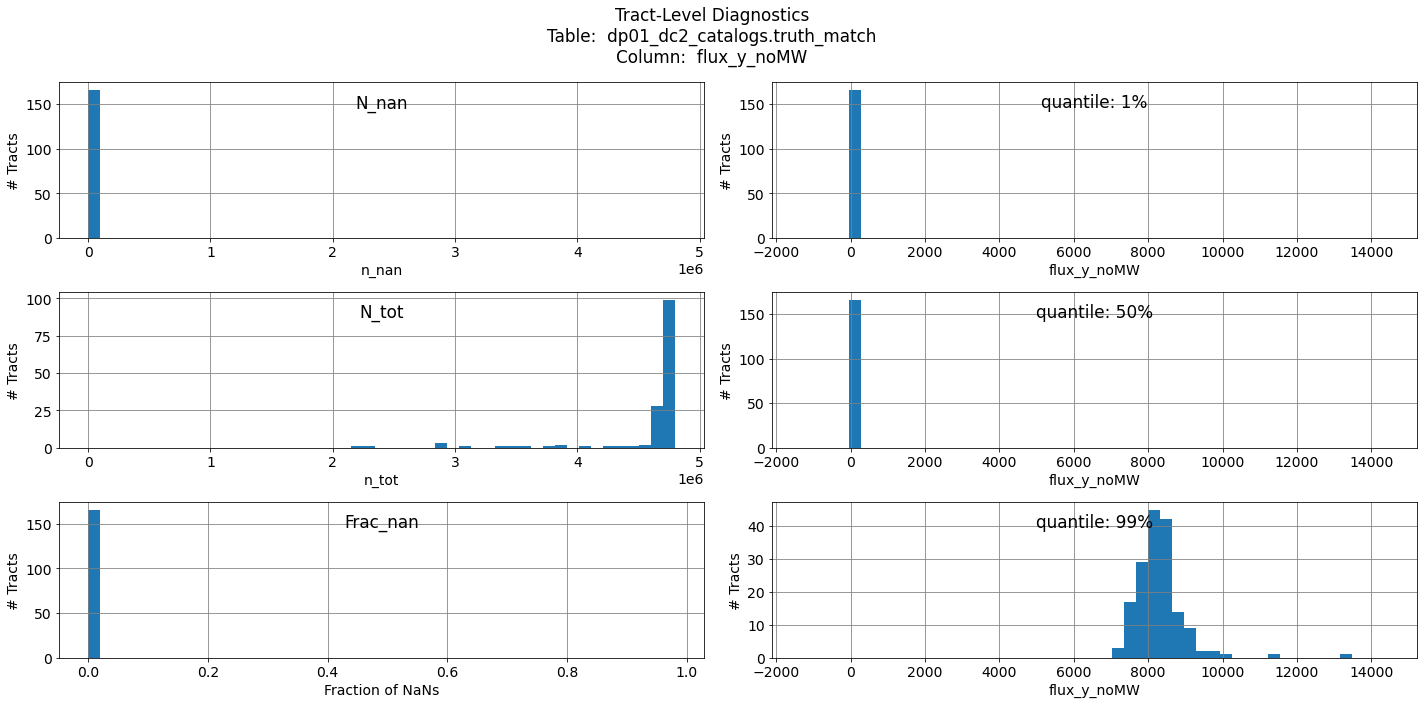

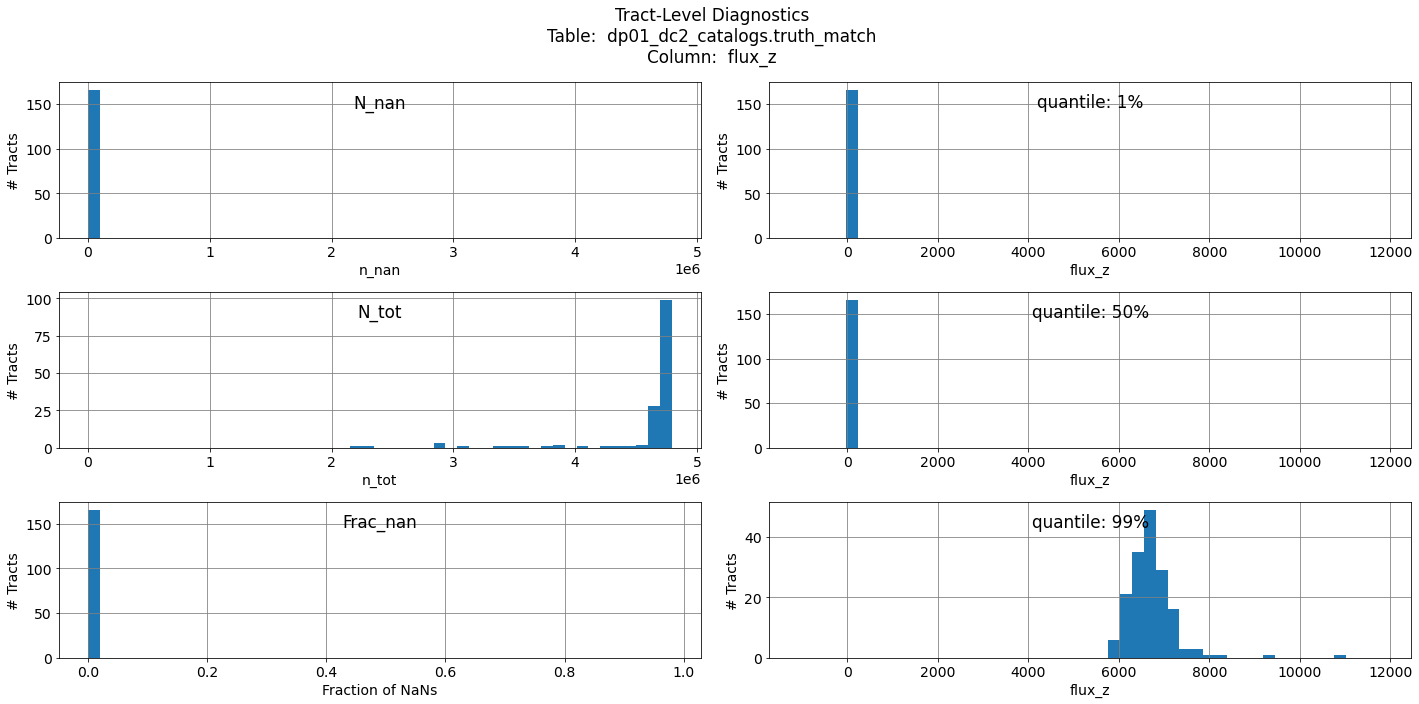

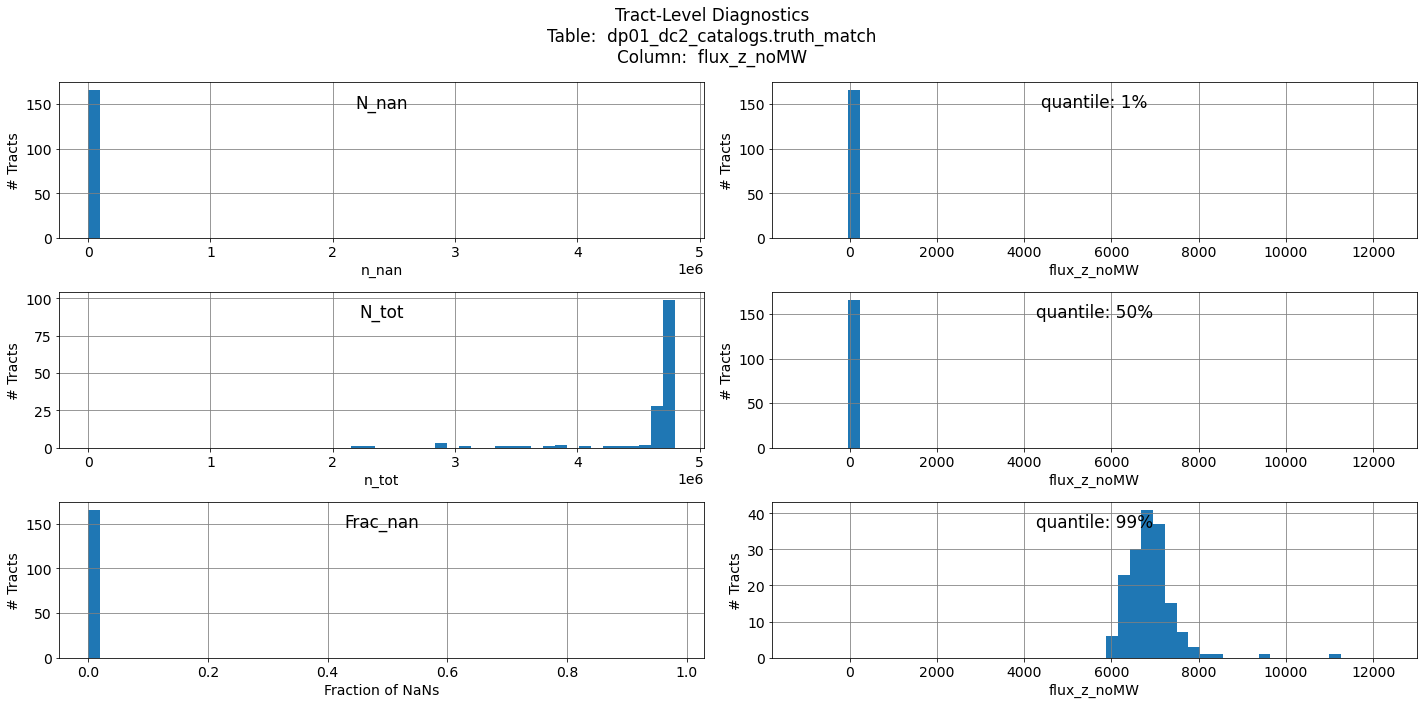

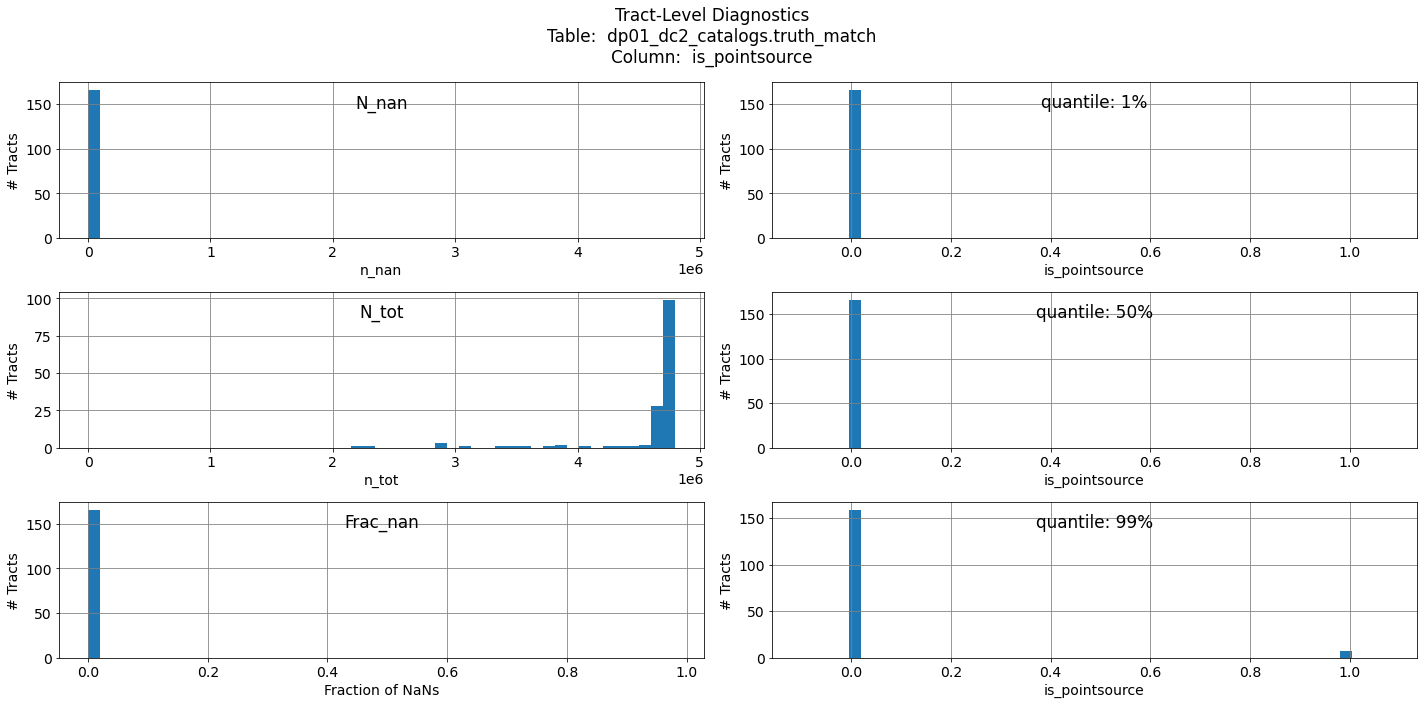

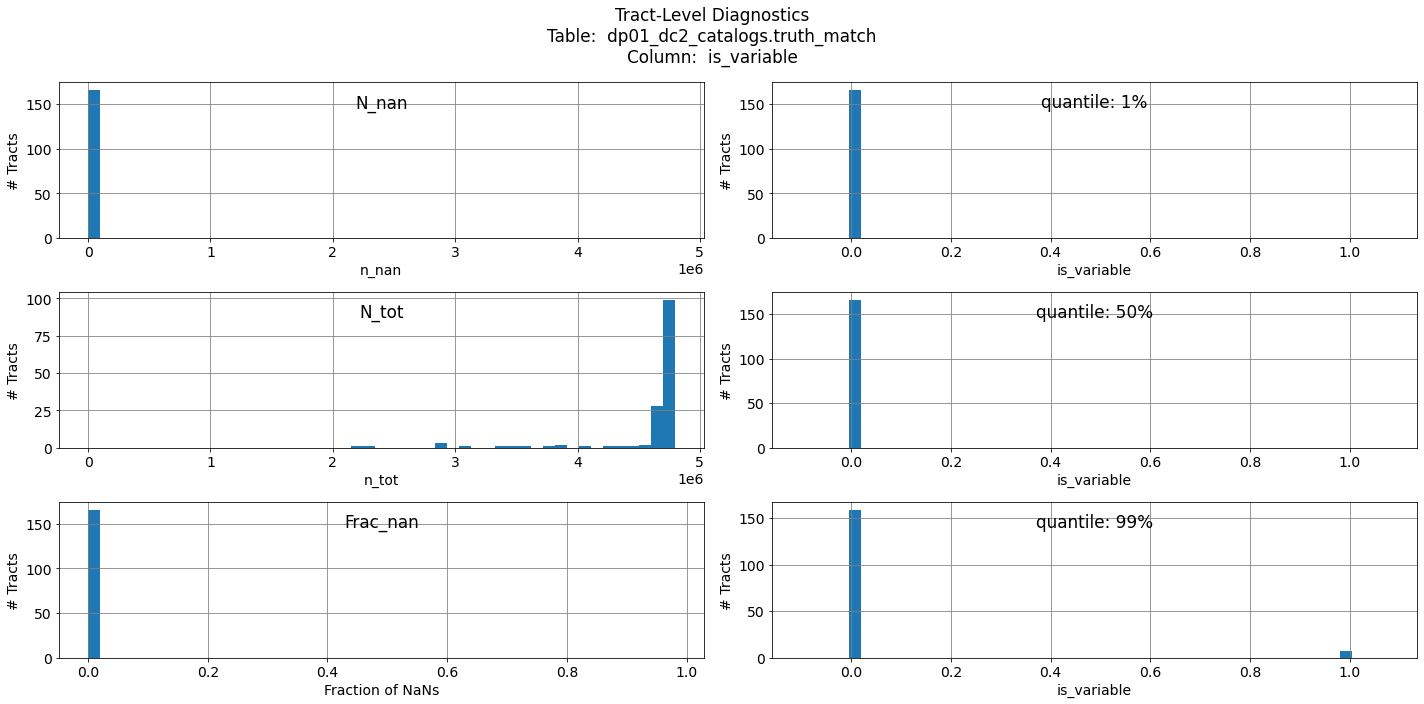

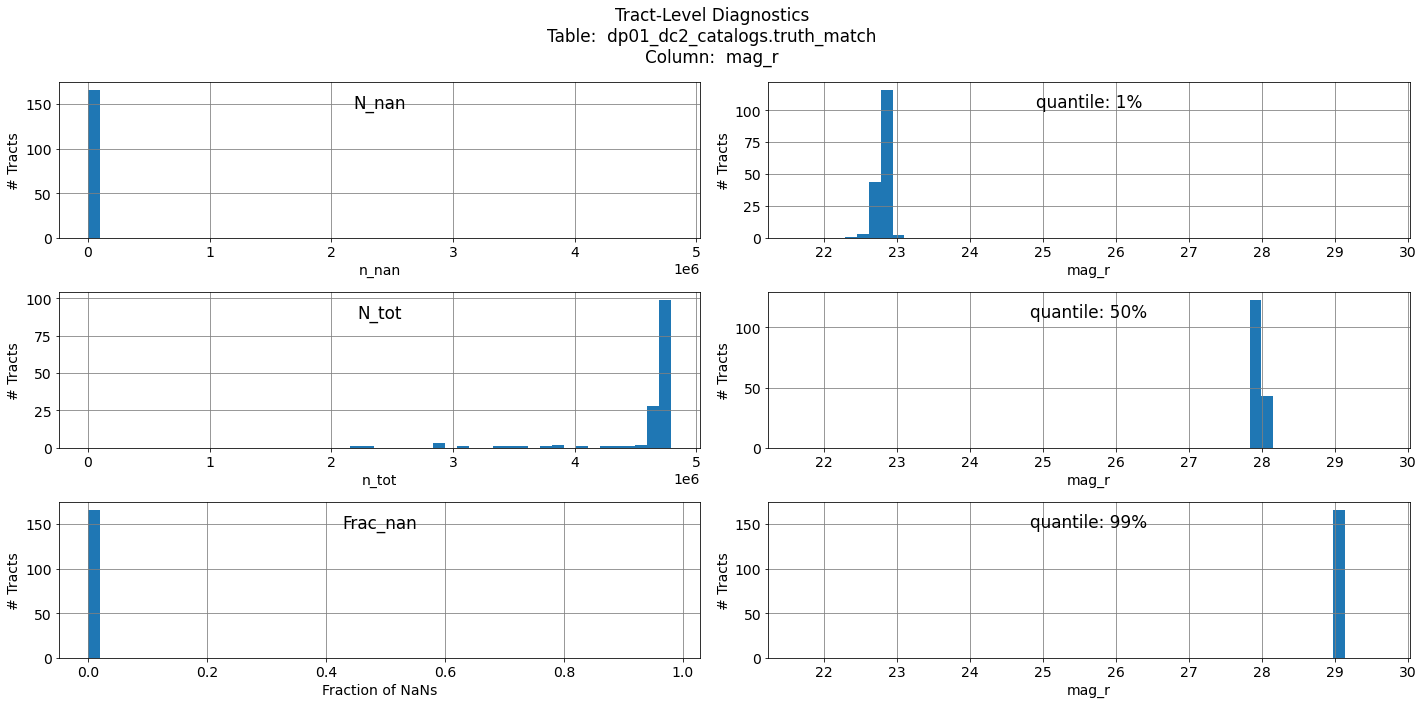

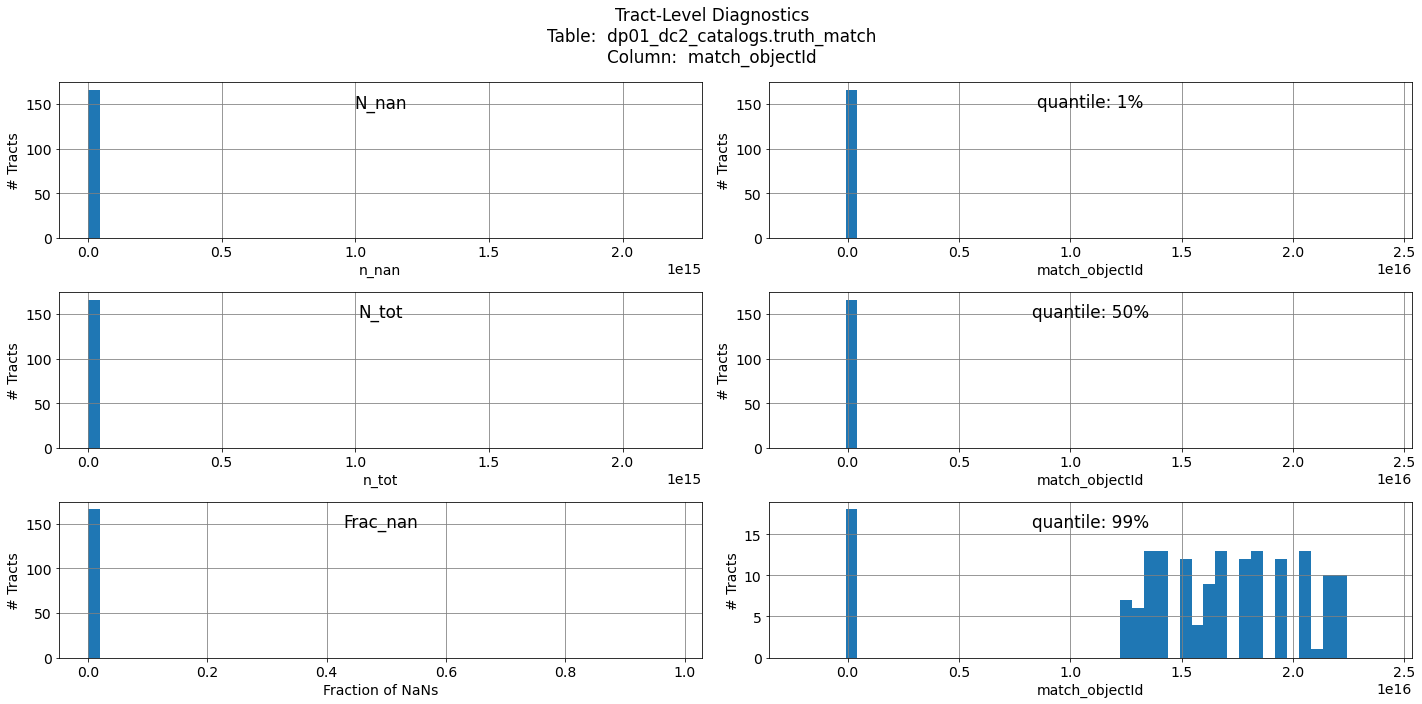

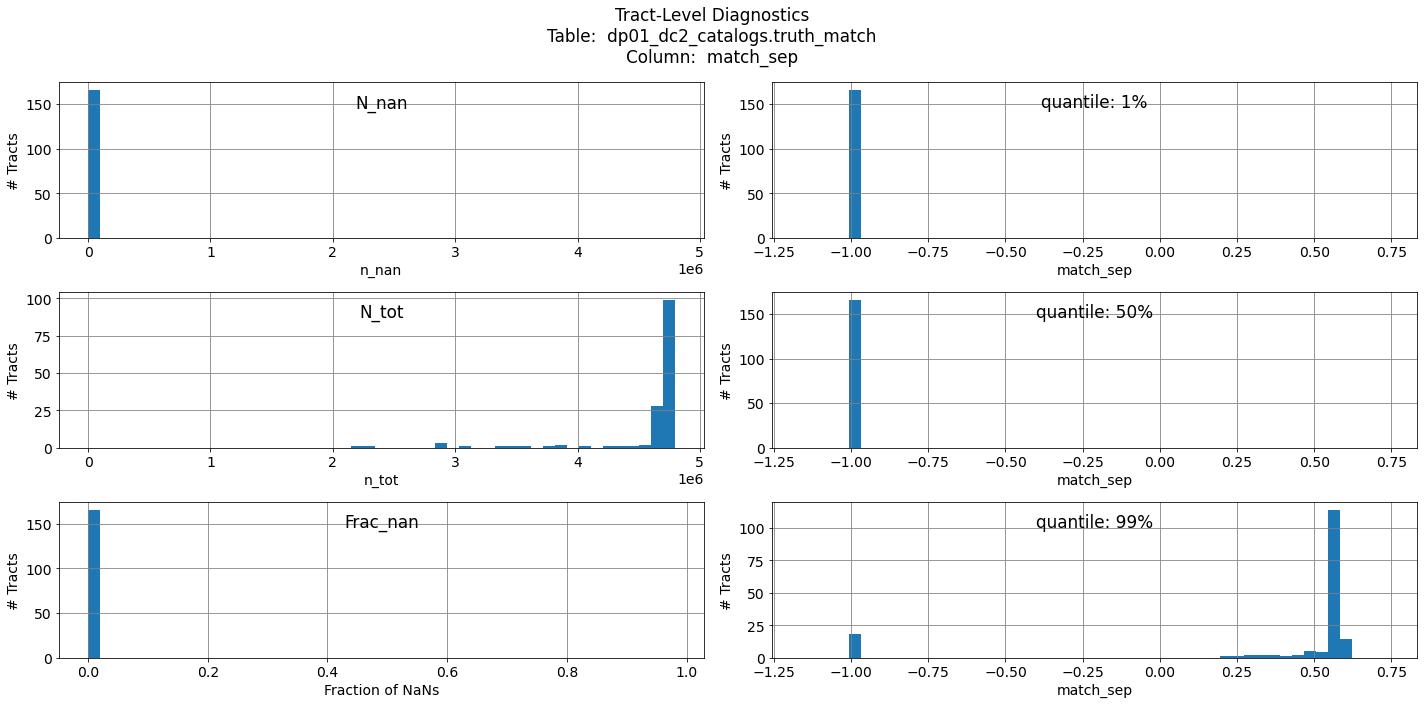

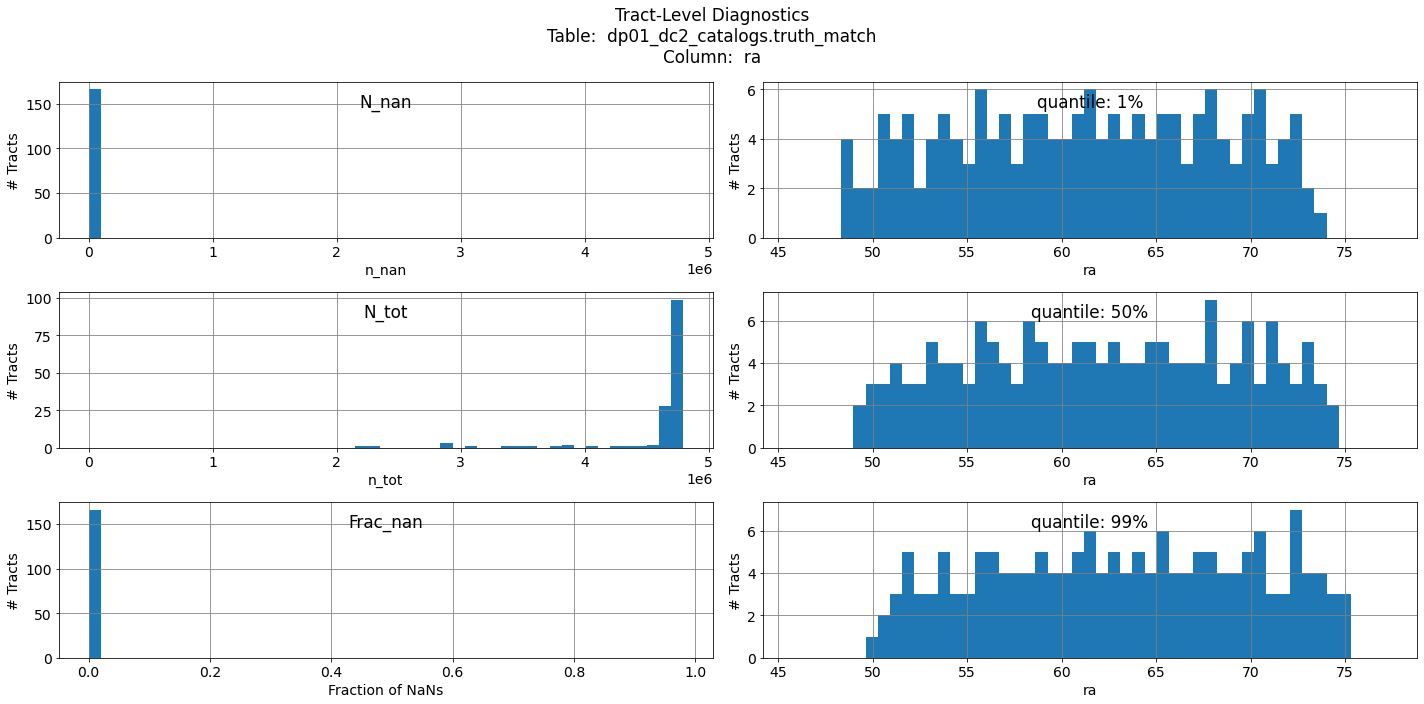

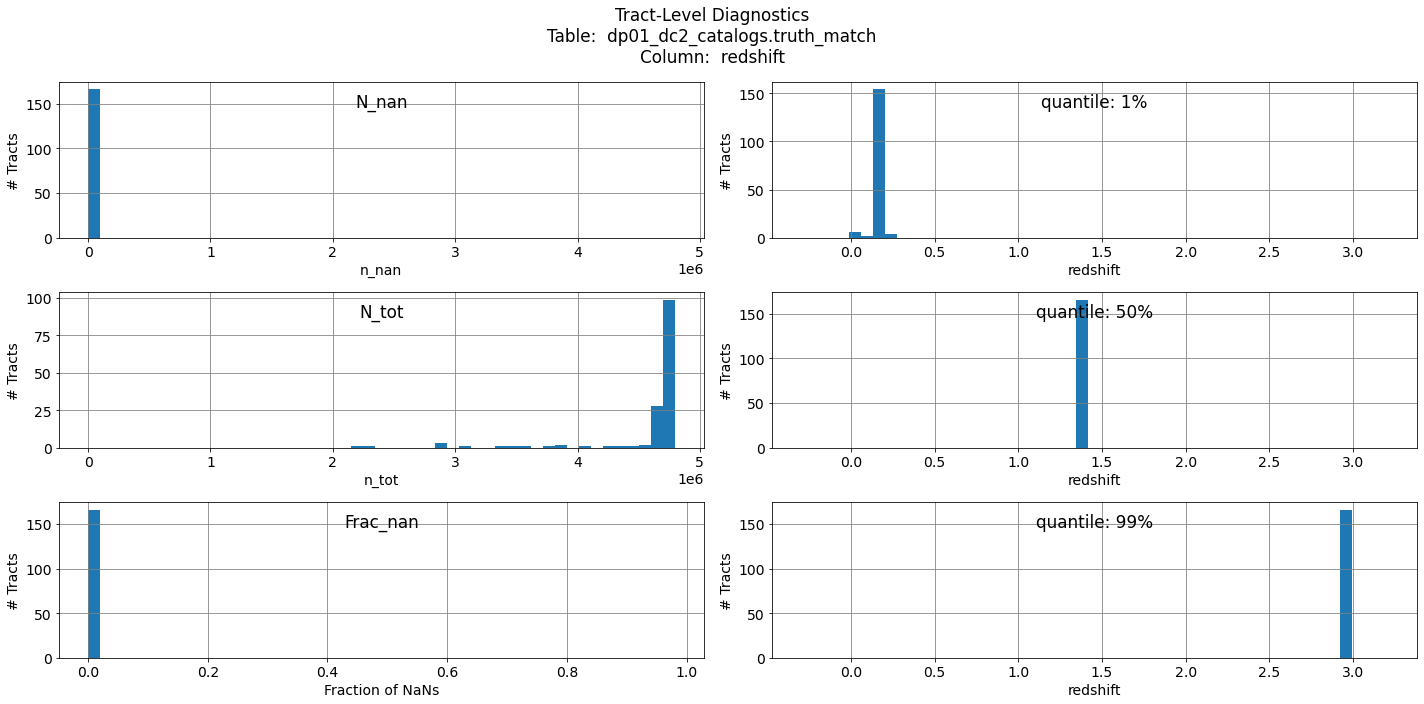

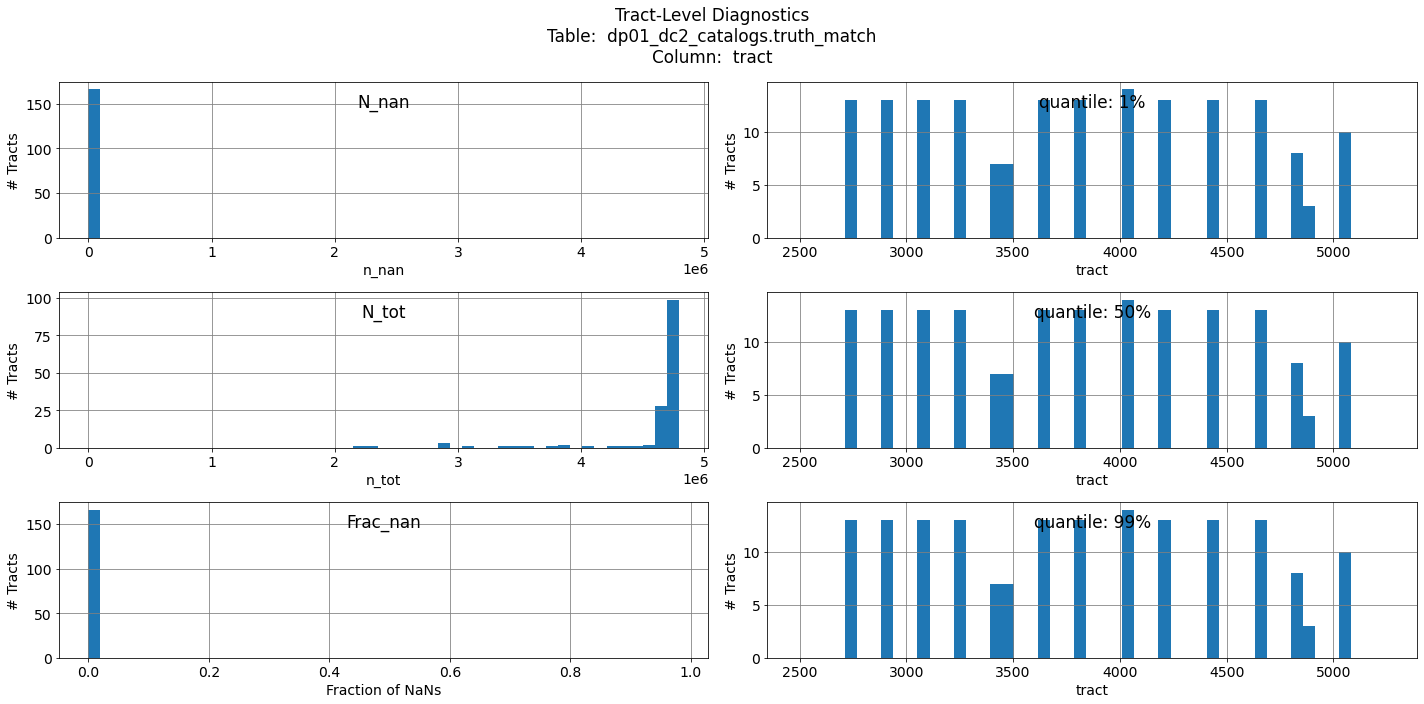

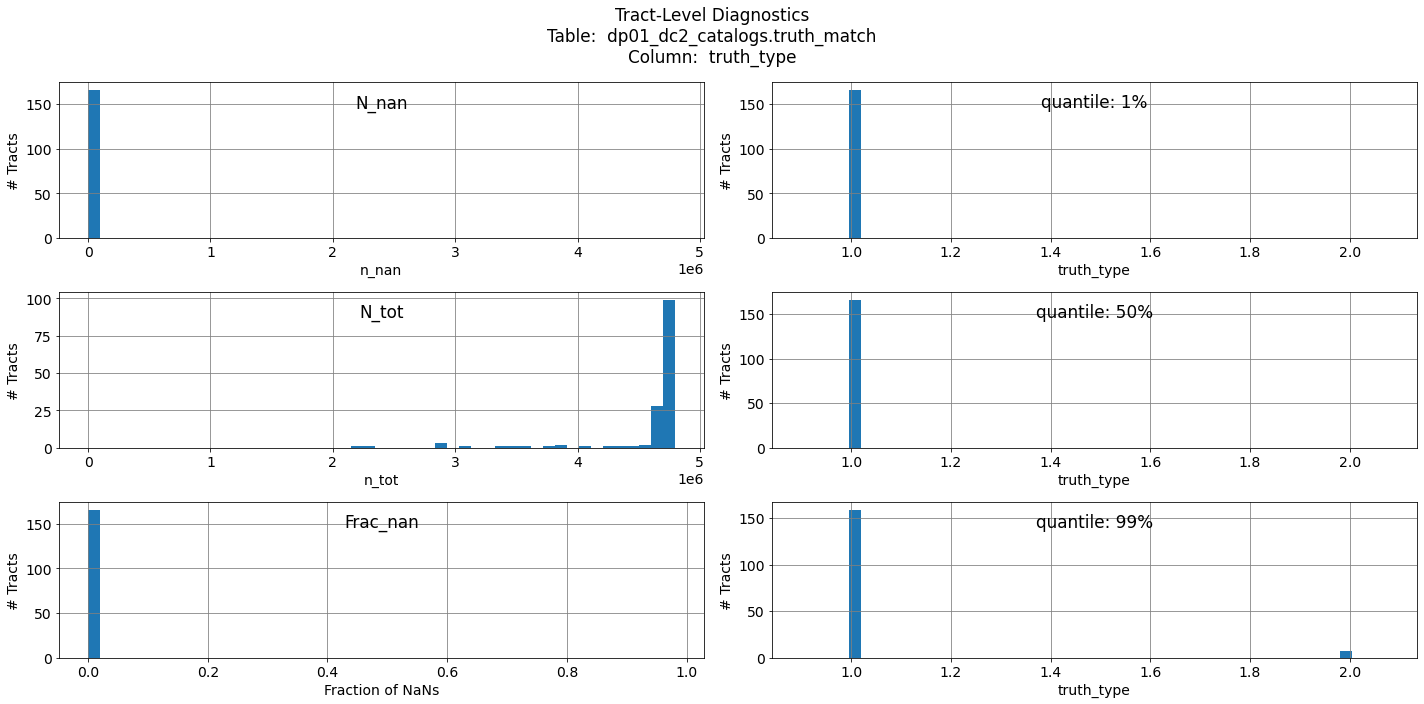

In [17]:
colnames_set = set(meta_df.column)
colnames_list = (list(colnames_set))
colnames_list.sort()

for colname in colnames_list:
    print(colname+':  ', end = '')
    try:
        outputFileName = """%s.%s.%s.png""" % (baseName, table_full_name, colname)
        print(outputFileName, end = '')
        outputFileName = os.path.join(outputDir, outputFileName)
        status = makeTractSanityPlots(meta_df, colname, table_full_name, outputFileName, nbins=50)
    except:
        print("   FAILED", end = '')
    print('')

In [18]:
#del meta_df

### Final Cleanup 

Let's delete all the leftover asynchronous job results.

In [19]:
# Cleanup for object results...

if do_final_cleanup == True:

    for tract in tract_list:

        i_tract = tract_list.index(tract) + 1
        
        try:
            job_url = df_urls.loc[tract, 'url']
            retrieved_job = retrieve_query(job_url)
            retrieved_job.delete()
            print("""Tract %d  (%d/%d):  JOB DELETED (%s)""" % (tract, i_tract, n_tracts, job_url))
        
        except:
            print("""Tract %d  (%d/%d):  JOB NOT FOUND (%s)""" % (tract, i_tract, n_tracts, job_url))